In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import panel as pn
import itertools
import math
import param

pn.extension()

In [8]:
image_dir = Path("../images/timestep-global-map/")
files = list(image_dir.rglob("*.png"))
files[10:13]

[PosixPath('../images/timestep-global-map/SiO3+0002-03-16 12:00:00+z_t@500.0.png'),
 PosixPath('../images/timestep-global-map/SiO3+0003-06-16 00:00:00+z_t@35109.34765625.png'),
 PosixPath('../images/timestep-global-map/SiO3+0004-01-16 12:00:00+log_10@True+z_t@500.0.png')]

In [11]:
entries = []
for file in files:
    path = file.as_posix()
    if "checkpoint" in path:
        continue
    parts = file.stem.split("+")
    x = dict(varname=parts[0], time=parts[1], path=path)
    if len(parts) > 2:
        for part in parts[2:]:
            y = part.split("@")
            x[y[0]] = y[1]
            if y[0].startswith("z_t"):

                x["depth_level"] = y[1]
    entries.append(x)

df = pd.DataFrame(entries)

df["z_t"] = df["z_t"].astype(float)
df["z_t_150m"] = df["z_t_150m"].astype(float)
df["depth_level"] = df["depth_level"].astype(float)
df["depth_level"] = df["depth_level"].fillna(-9999)
df["log_10"] = df.log_10.map(lambda x: True if x == "True" else False)

grouped = df.groupby(["varname", "time", "depth_level", "log_10"])
df.head()

,varname,time,path,z_t_150m,depth_level,log_10,z_t
0,photoC_cocco_zint,0004-02-15 00:00:00,../images/timestep-global-map/photoC_cocco_zin...,NaN,-9999.0,False,NaN
1,photoC_diat_zint,0002-12-16 12:00:00,../images/timestep-global-map/photoC_diat_zint...,NaN,-9999.0,False,NaN
2,O2_ZMIN_DEPTH,0004-04-16 00:00:00,../images/timestep-global-map/O2_ZMIN_DEPTH+00...,NaN,-9999.0,False,NaN
3,diatChl,0002-05-16 12:00:00,../images/timestep-global-map/diatChl+0002-05-...,500.0,500.0,False,NaN
4,CaCO3_FLUX_100m,0001-08-16 12:00:00,../images/timestep-global-map/CaCO3_FLUX_100m+...,NaN,-9999.0,True,NaN


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   varname      1134 non-null   object 
 1   time         1134 non-null   object 
 2   path         1134 non-null   object 
 3   z_t_150m     150 non-null    float64
 4   depth_level  1134 non-null   float64
 5   log_10       1134 non-null   bool   
 6   z_t          349 non-null    float64
dtypes: bool(1), float64(3), object(3)
memory usage: 54.4+ KB


Column
    [0] Markdown(str)
    [1] Row(sizing_mode='stretch_both')
        [0] Column
            [0] Row
                [0] Column(margin=5, width=300)
                    [0] StaticText(value='<b></b>')
                    [1] Select(name='Variable', options=OrderedDict([('photoC_cocc...]), value='CaCO3_FLUX_100m')
                    [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999)
                    [3] Checkbox(name='Apply log10')
                    [4] Select(name='Time', options=OrderedDict([('0001-01-16 ...]), value='0001-01-16 12:15:50')
            [1] Row
                [0] ParamMethod(method)
        [1] Column
            [0] Row
                [0] Column(margin=5, width=300)
                    [0] StaticText(value='<b></b>')
                    [1] Select(name='Variable', options=OrderedDict([('photoC_cocc...]), value='O2_ZMIN_DEPTH')
                    [2] Select(name='Depth level', options=OrderedDict([('-9999.0', ...]), value=-9999)
                    [3] Checkbox(name='Apply log10')
                    [4] Select(name='Time', options=OrderedDict([('0001-01-16 ...]), value='0001-01-16 12:15:50')
            [1] Row
                [0] ParamMethod(method)
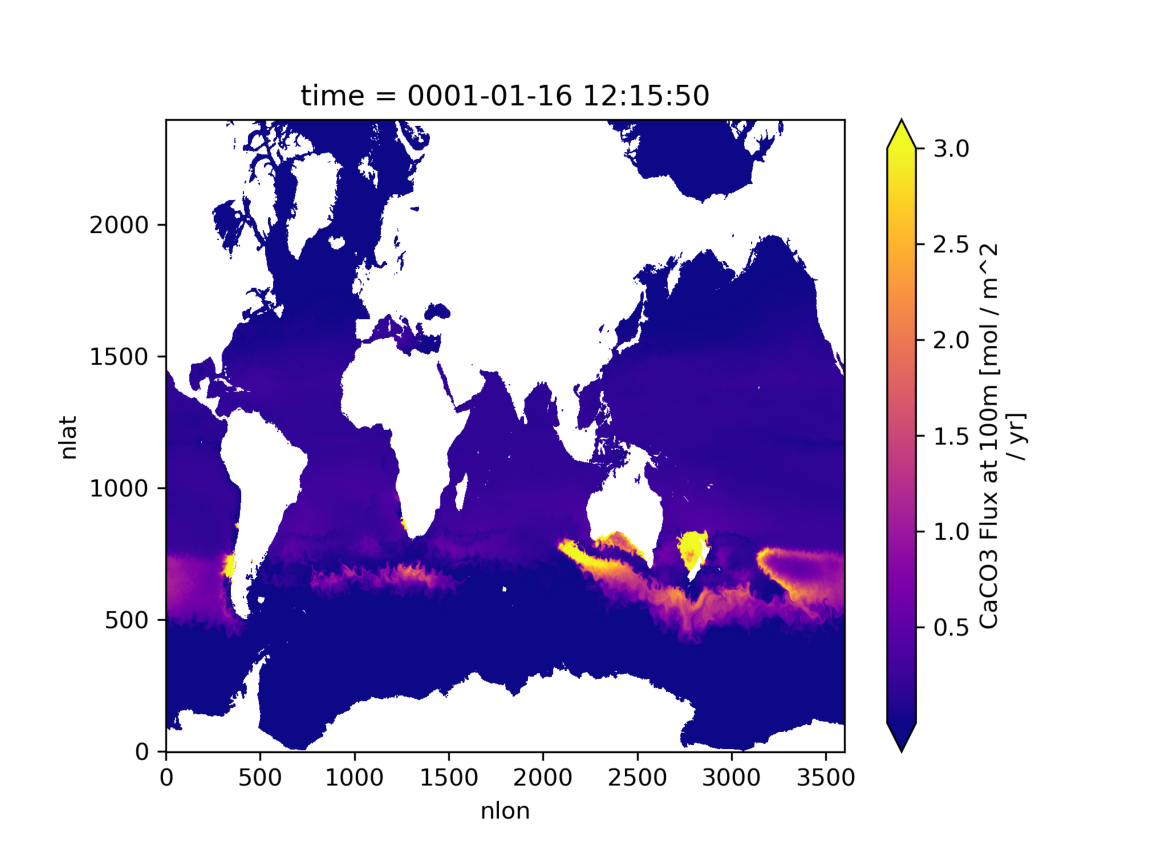
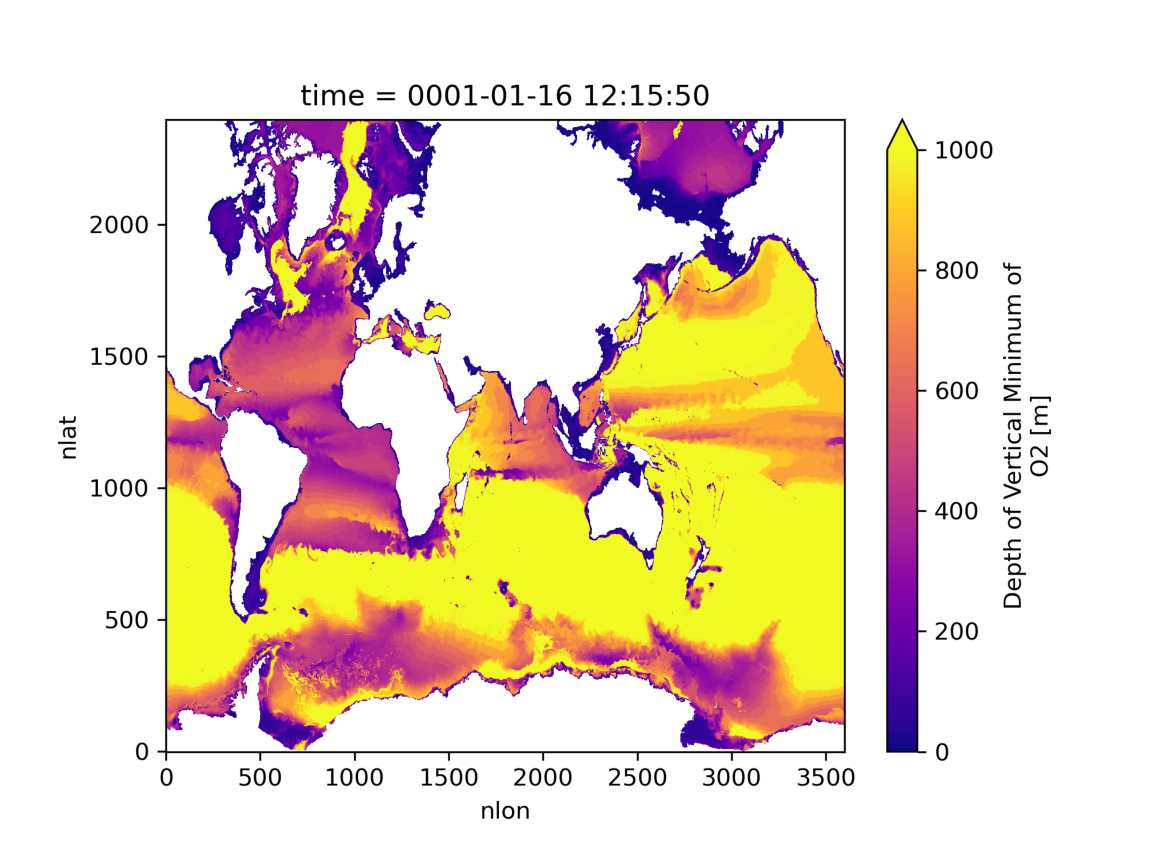

In [14]:
class BaseDashboard(param.Parameterized):
    variable = param.ObjectSelector(
        default="CaCO3_FLUX_100m", objects=df.varname.unique().tolist()
    )
    depth_level = param.ObjectSelector(
        default=-9999, objects=df.depth_level.unique().tolist()
    )
    apply_log10 = param.Boolean(default=False)

    def get_data(self):
        raise NotImplementedError()

    def plot(self):
        raise NotImplementedError()


class TimestepDashboard(BaseDashboard):
    time = param.Selector(objects=sorted(df.time.unique().tolist()))
    grouped = df.groupby(["varname", "time", "depth_level", "log_10"])

    def get_data(self):
        key = self.variable, self.time, self.depth_level, self.apply_log10
        df = self.grouped.get_group(key)
        return df

    def plot(self):
        try:
            df = self.get_data()
            path = df.iloc[0].path
            data = img.imread(path)
            nrows, ncols = 1, 1
            fig, ax = plt.subplots(
                nrows=nrows, ncols=ncols, figsize=(8, 6), squeeze=True
            )
            ax.imshow(data)
            ax.axis("off")
            plt.tight_layout()
            plt.close(fig)
            return fig
        except KeyError:
            pass


dd_left = TimestepDashboard(name="")
dd_right = TimestepDashboard(name="", variable="O2_ZMIN_DEPTH")
one_timestep_dashboard = pn.Column(
    "# Time Slice Global Map",
    pn.Row(
        pn.Column(pn.Row(dd_left.param), pn.Row(dd_left.plot)),
        pn.Column(pn.Row(dd_right.param), pn.Row(dd_right.plot)),
        sizing_mode="stretch_both",
    ),
)
one_timestep_dashboard